# Multi-headed CNN model
see: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [5]:
# Import statements
import tensorflow as tf
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
import h5py
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Plot formatting defaults
plt.rc('ytick', direction='out')
plt.rc('grid', color='w', linestyle='solid')
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', direction='out')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [ ]:
# Load in train and test data

mat = scipy.io.loadmat('W8_samples.mat')
W8_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W9_samples.mat')
W9_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W10_samples.mat')
W10_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W5_samples.mat')
W5_cell_data = mat['cell_data']

del mat

X_train, y_train = shuffle(W8_cell_data[:,1:], W8_cell_data[:,0])

X_test = W9_cell_data[:,1:]
y_test = W9_cell_data[:,0]

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_train = np.transpose(np.reshape(X_train, (X_train.shape[0], 2, int(X_train.shape[1]/2))), (0, 2, 1))
X_test = np.transpose(np.reshape(X_test, (X_test.shape[0], 2, int(X_test.shape[1]/2))), (0, 2, 1))

# Split into two vectors: one for voltage, one for current
X_trainVolts = X_train[:,:,0]
X_trainAmps = X_train[:,:,1]
X_testVolts = X_test[:,:,0]
X_testAmps = X_test[:,:,1]

# Split off and reserve dev set from train set
X_trainVolts, X_devVolts, X_trainAmps, X_devAmps, y_train, y_dev = train_test_split(X_trainVolts, X_trainAmps, y_train, test_size=0.1, shuffle= True)

# Save dimensions for LSTM
n_feat = X_train.shape[1]

#W10 cell data
X_test_W10 = W10_cell_data[:,1:]
y_test_W10 = W10_cell_data[:,0]

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_test_W10 = np.transpose(np.reshape(X_test_W10, (X_test_W10.shape[0], 2, int(X_test_W10.shape[1]/2))), (0, 2, 1))

X_testVolts_W10 = X_test_W10[:,:,0]
X_testAmps_W10 = X_test_W10[:,:,1]

#W5 cell data
X_test_W5 = W5_cell_data[:,1:]
y_test_W5 = W5_cell_data[:,0]

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_test_W5 = np.transpose(np.reshape(X_test_W5, (X_test_W5.shape[0], 2, int(X_test_W5.shape[1]/2))), (0, 2, 1))

X_testVolts_W5 = X_test_W5[:,:,0]
X_testAmps_W5 = X_test_W5[:,:,1]

print(X_trainVolts.shape)
print(X_trainAmps.shape)


In [8]:
# Rescale output to min 0, max 1:
min_max_scaler = MinMaxScaler().fit(np.concatenate((y_train, y_test, y_dev, y_test_W10, y_test_W5)).reshape((-1,1)))

y_train_scaled = min_max_scaler.transform(y_train.reshape((-1,1))).reshape(-1,)
y_test_scaled = min_max_scaler.transform(y_test.reshape((-1,1))).reshape(-1,)
y_dev_scaled = min_max_scaler.transform(y_dev.reshape((-1,1))).reshape(-1,)
y_test_W10_scaled = min_max_scaler.transform(y_test_W10.reshape((-1,1))).reshape(-1,)
y_test_W5_scaled = min_max_scaler.transform(y_test_W5.reshape((-1,1))).reshape(-1,)


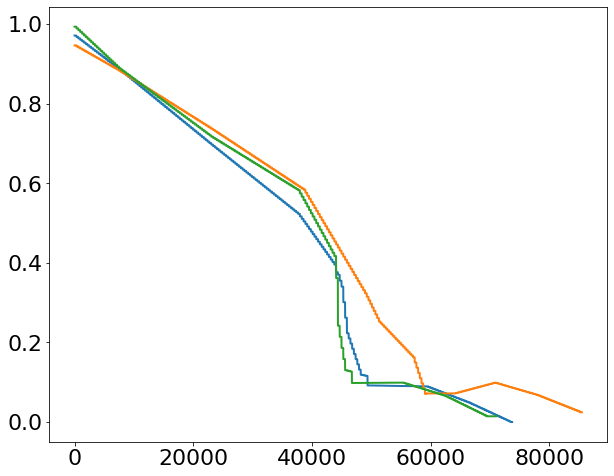

In [114]:
# Plot of all test true output (capacity) data
plt.plot(y_test_W10_scaled)
plt.plot(y_test_W5_scaled)
plt.plot(y_test_scaled)
plt.show()

In [9]:
# Downsample test by 1/10th
y_test_ds = y_test_scaled[0::10]
X_testVolts_ds= X_testVolts[0::10, :]
X_testAmps_ds= X_testAmps[0::10, :]

y_test_W10_ds = y_test_W10_scaled[0::10]
X_testVolts_W10_ds= X_testVolts_W10[0::10, :]
X_testAmps_W10_ds= X_testAmps_W10[0::10, :]

y_test_W5_ds = y_test_W5_scaled[0::10]
X_testVolts_W5_ds= X_testVolts_W5[0::10, :]
X_testAmps_W5_ds = X_testAmps_W5[0::10, :]

In [ ]:
# Downsample train and dev by 1/10th for tuning
X_trainVolts_ds = X_trainVolts[0::10, :]
X_trainAmps_ds = X_trainAmps[0::10, :]
y_train_ds = y_train_scaled[0::10]

X_devVolts_ds = X_devVolts[0::10, :]
X_devAmps_ds = X_devAmps[0::10, :]
y_dev_ds = y_dev_scaled[0::10]

# print(X_trainVolts_ds.shape)
# print(X_trainAmps_ds.shape)
# print(y_train_ds.shape)

# print(X_devVolts_ds.shape)
# print(X_devAmps_ds.shape)
# print(y_dev_ds.shape)

## Model initialization and fit

In [142]:
# 1D CNN for current and voltage data
def create_1d_cnn(feat, chan):

    inputShape = (feat, chan,)

    # define the model input
    inputs = layers.Input(shape=inputShape)
 
    x = inputs

    x = layers.Conv1D(32, 10)(x)
    x = layers.MaxPool1D(pool_size=(4))(x)
    x = layers.Conv1D(16, 5)(x)
    x = layers.MaxPool1D(pool_size=(2))(x)
    x = layers.Conv1D(8, 5)(x)
    x = layers.MaxPool1D(pool_size=(2))(x)
    x = layers.Conv1D(8, 5)(x)
    x = layers.MaxPool1D(pool_size=(2))(x)
    x = layers.Flatten()(x)

    model = tf.keras.models.Model(inputs, x)

    return model

In [146]:
# create the CNN models for voltage and current
cnnVolts = create_1d_cnn(1200, 1)
cnnAmps = create_1d_cnn(1200, 1)

# create the input to our final set of layers as the output of both the CNNs
combinedInput = layers.concatenate([cnnVolts.output, cnnAmps.output])

# final layer will have two dense layers, the final one being regression
x = layers.Dense(100, activation="relu")(combinedInput)
x = layers.Dense(1, activation="linear")(x)

model = tf.keras.models.Model(inputs=[cnnVolts.input, cnnAmps.input], outputs=x)

In [147]:
model.summary()

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 1200, 1)]    0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 1200, 1)]    0           []                               
                                                                                                  
 conv1d_102 (Conv1D)            (None, 1191, 32)     352         ['input_39[0][0]']               
                                                                                                  
 conv1d_106 (Conv1D)            (None, 1191, 32)     352         ['input_40[0][0]']               
                                                                                           

In [148]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="mean_squared_error",
    metrics=["mean_squared_error"],
)

history = model.fit(x=[X_trainVolts, X_trainAmps], y=y_train_scaled,
                    validation_data=([X_devVolts, X_devAmps], y_dev_scaled),
                    epochs=500,
                    verbose=2,
                    batch_size=92)


Epoch 1/500


2022-05-25 12:21:39.219271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-25 12:21:54.780406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


792/792 - 20s - loss: 0.1216 - mean_squared_error: 0.1216 - val_loss: 0.1207 - val_mean_squared_error: 0.1207 - 20s/epoch - 25ms/step
Epoch 2/500
792/792 - 15s - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1204 - val_mean_squared_error: 0.1204 - 15s/epoch - 19ms/step
Epoch 3/500
792/792 - 15s - loss: 0.1199 - mean_squared_error: 0.1199 - val_loss: 0.1205 - val_mean_squared_error: 0.1205 - 15s/epoch - 19ms/step
Epoch 4/500
792/792 - 15s - loss: 0.1194 - mean_squared_error: 0.1194 - val_loss: 0.1202 - val_mean_squared_error: 0.1202 - 15s/epoch - 19ms/step
Epoch 5/500
792/792 - 15s - loss: 0.1184 - mean_squared_error: 0.1184 - val_loss: 0.1192 - val_mean_squared_error: 0.1192 - 15s/epoch - 19ms/step
Epoch 6/500
792/792 - 15s - loss: 0.1172 - mean_squared_error: 0.1172 - val_loss: 0.1171 - val_mean_squared_error: 0.1171 - 15s/epoch - 19ms/step
Epoch 7/500
792/792 - 15s - loss: 0.1154 - mean_squared_error: 0.1154 - val_loss: 0.1141 - val_mean_squared_error: 0.1141 - 15s/epoch - 

In [ ]:
# Save completed model
model.save("mix-cnn-model_norm_w8_500")

In [43]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


## Validation

In [ ]:
# Load model
# model = keras.models.load_model("mix-cnn-model_w8_300")
# model = keras.models.load_model("mixmodel_w8_200")
model = keras.models.load_model("mix-cnn-model_norm_W8_500")

### Validation on W9 cell

223/223 [==============================] - 1s 4ms/step


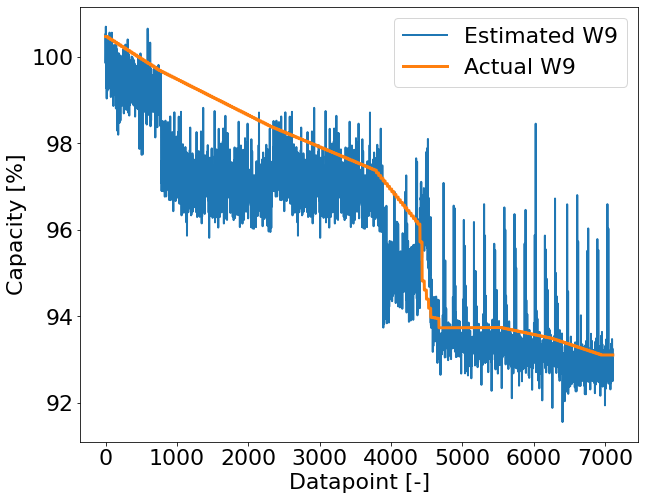

0.015058155779702879


In [12]:
y_hat = model.predict([X_testVolts_ds, X_testAmps_ds])
y_hat_plot = min_max_scaler.inverse_transform(y_hat.reshape((-1,1)))
y_test_plot = min_max_scaler.inverse_transform(y_test_ds.reshape((-1,1)))
# y_hat_plot = np.ravel(y_hat)
plt.plot(y_hat_plot*100)
plt.plot(y_test_plot*100, linewidth=3)
plt.legend(['Estimated W9', 'Actual W9'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()

print(mean_squared_error(y_hat_plot, y_test_plot)*100)

# model.evaluate([X_testVolts_ds, X_testAmps_ds], y_test_ds, verbose=2)

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.legend(['Training', 'Validation'])
# plt.xlabel("Epoch [-]")
# plt.ylabel("Loss [%]")
# plt.show()

In [ ]:
# TODO: Try ``filtering'' -- at each cycle, average across all of the values  suggested by the model

### Validation on W10 cell

231/231 [==============================] - 1s 3ms/step


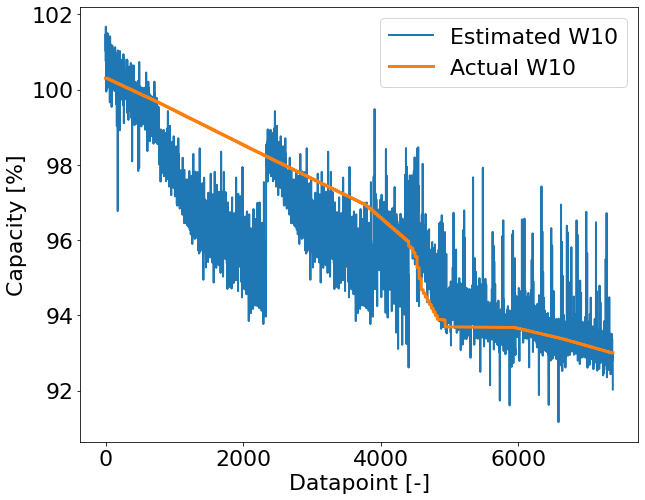

0.02047957916743067


In [14]:
y_hat_W10 = model.predict([X_testVolts_W10_ds, X_testAmps_W10_ds])
y_hat_plot_W10 = min_max_scaler.inverse_transform(y_hat_W10.reshape((-1,1)))
y_test_plot_W10 = min_max_scaler.inverse_transform(y_test_W10_ds.reshape((-1,1)))
# y_hat_plot_W10 = np.ravel(y_hat_W10)
plt.plot(y_hat_plot_W10*100)
plt.plot(y_test_plot_W10*100, linewidth=3)
plt.legend(['Estimated W10', 'Actual W10'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()

print(mean_squared_error(y_hat_plot_W10, y_test_plot_W10)*100)

# model.evaluate([X_testVolts_W10_ds, X_testAmps_W10_ds], y_test_W10_ds, verbose=2)

### Validation on W5 cell

268/268 [==============================] - 1s 3ms/step


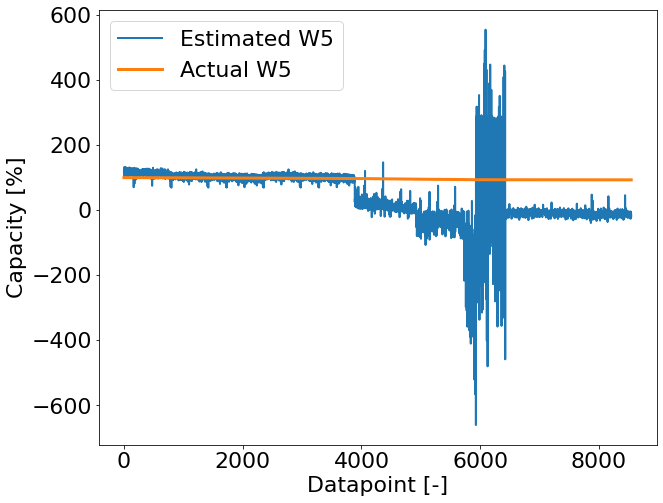

83.16210620499285


In [17]:
y_hat_W5 = model.predict([X_testVolts_W5_ds, X_testAmps_W5_ds])
y_hat_plot_W5 = np.ravel(y_hat_W5)
y_test_plot_W5 = min_max_scaler.inverse_transform(y_test_W5_ds.reshape((-1,1)))
plt.plot(y_hat_plot_W5*100)
plt.plot(y_test_plot_W5*100, linewidth=3)
plt.legend(['Estimated W5', 'Actual W5'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()


print(mean_squared_error(y_hat_plot_W5, y_test_plot_W5)*100)

# model.evaluate([X_testVolts_W10_ds, X_testAmps_W10_ds], y_test_W10_ds, verbose=2)
